In [514]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### A) Load Training Data

In [515]:
def load_data(imgs, gts):
    '''
    load rgb images and ground truths; 
    calculate the priors for apple pixels and non-apple pixels priors.
    
    Keyword arguments:
    imgs -- rgb images for training
    gts -- the corresponding ground truth for the images
    '''
    data_true = []
    data_false = []
    for img, gt in zip(imgs, gts):
        # load images
        image = plt.imread(img)
        image = image / 255 # set the pixel values between [0,1]
        gtruth = (plt.imread(gt)[:,:,0]).astype(int) # ground truth, which only needs 1 channel to construct
        # split the data into apple and non-apple pixels
        for i in range(gtruth.shape[0]):
            for j in range(gtruth.shape[1]):
                if gtruth[i, j] == 1.0:
                    data_true.append(image[i,j])
                else:
                    data_false.append(image[i,j])
    # reshape the data to d x n
    data_true = np.array(data_true).T
    data_false = np.array(data_false).T
    # calculate the priors
    pixels = data_false.shape[1] + data_true.shape[1]
    prior = [data_true.shape[1]/ pixels, data_false.shape[1]/ pixels]
    # print('data_true: {} ; data_false: {}'.format(data_true.shape, data_false.shape))
    return data_true, data_false, prior

### B) Use mixtures of Gaussians to distinguish apple vs. non-apple pixels.

##### Gaussian Probability

In [516]:
def gaussProb(data, mean, cov):
    """
    Returns the gaussian probability of the data
    
    Keyword arguments:
    data: d x n matrix containing data points
    mean: d x 1 vector containing mean parameter of the Gaussian distribution
    cov: d x d matrix covariance parameter of the Gaussian distribution
    """
    nDim = data.shape[0]
    diff = data - mean.reshape(nDim,1)
    brac = (diff.T.dot(np.linalg.inv(cov)) * diff.T).sum(1)
    prob = (np.linalg.det(2 * np.pi * cov)**-0.5) * np.exp(-0.5 * brac)
    return prob

##### Likelihood & Loglikelihood

In [517]:
def likelihood(data, mixGaussEst, log=0):
    """
    Returns the likelihood or log likelihood for the whole data set under a mixture of Gaussian

    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.
    log -- boolean. 1 returns log likelihood, 0 returns likelihood. Default is 0.
    Returns: 
    logLike -- scalar containing the log likelihood.
    """
    nData = data.shape[1]
    like = np.zeros((mixGaussEst['k'], nData))
    for k in range(mixGaussEst['k']):
        update_weight = mixGaussEst['weight'][k]
        update_mean = mixGaussEst['mean'][:, k]
        update_cov = mixGaussEst['cov'][:, :, k]
        like[k, :] = update_weight * gaussProb(data, update_mean, update_cov)
    if log == 0:
        likelihood = np.sum(like, axis=0)
    elif log == 1:
        likelihood = np.sum(np.log(np.sum(like, axis=0)))
    return likelihood

##### EM Algorithm

In [518]:
def fit_gaussian(data, k, nIter):
    '''
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.

    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    nIter -- scalar representing the number of iteration.

    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    '''
    nDim, nData = data.shape

    # initialise values to some random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDim
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDim, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDim, nDim, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDim)

    logLike = log_likelihood(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    postHidden = np.zeros(shape=(k, nData))
    for cIter in range(nIter):
        ### Expectation step ###
        for i in range(k):
            weight = mixGaussEst['weight'][i]
            mean = mixGaussEst['mean'][:,i]
            cov = mixGaussEst['cov'][:,:,i]
            postHidden[i,:] = weight * gaussProb(data, mean, cov)
        postHidden /= np.sum(postHidden, axis=0) + 1e-20 # aviod singularity

        ### Maximization Step ###
        for i in range(k):
            r_ij = postHidden[i,:] # current responsibility
            mixGaussEst['weight'][i] = np.sum(r_ij) / np.sum(postHidden)
            mixGaussEst['mean'][:,i] = (data@postHidden[i,:])/np.sum(r_ij)
            mixGaussEst['cov'][:,:,i] =  ((data - mixGaussEst['mean'][:,i].reshape(nDim,1))*postHidden[i,:]).dot((data - mixGaussEst['mean'][:,i].reshape(nDim,1)).T) / np.sum(r_ij)
        
        # calculate the log likelihood
        logLike = likelihood(data, mixGaussEst, log=1)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter+1, logLike))
    return mixGaussEst

In [563]:
def posterior(im_path, prior, trueEst, falseEst):
    '''
    Returns the posterior of each pixel of a test image of being an apple pixel

    Keyword arguments:
    im_path -- path of the test image.
    prior -- the priors for apple pixels and non-apple pixels priors.
    trueEst -- dict containing the estimated MoG parameters for the apple pixels.
    falseEst -- dict containing the estimated MoG parameters for the non apple pixels.

    '''
    # priors
    prior_true, prior_false = prior
    # set the values of the pixels in range [0,1]
    im = plt.imread(im_path)/255
    imY, imX, imZ = im.shape
    like_true = likelihood(im.reshape(imY*imX,imZ).T, trueEst).reshape(imY,imX)
    like_false = likelihood(im.reshape(imY*imX,imZ).T, falseEst).reshape(imY,imX)
    posterior_true = like_true * prior_true / (like_true * prior_true + like_false * prior_false)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
    ax1.imshow(im)
    ax1.set_title('Image')
    ax2.imshow(posterior_true)
    ax2.set_title('Posterior')
    return posterior_true

##### Now we can train the model using the images inside the apple folder

In [564]:
# paths for the training data
img_train = [
        './apples/Apples_by_kightp_Pat_Knight_flickr.jpg',
        './apples/ApplesAndPears_by_srqpix_ClydeRobinson.jpg',
        './apples/bobbing-for-apples.jpg'
    ]

train_gt = [
        './apples/Apples_by_kightp_Pat_Knight_flickr.png',
        './apples/ApplesAndPears_by_srqpix_ClydeRobinson.png',
        './apples/bobbing-for-apples.png'
    ]

# load the data
data_true, data_false, prior = load_data(img_train, train_gt)
data_true, data_false, prior = load_data(img_train, train_gt)

# train the data
mixGassEst_true = fit_gaussian(data_true, 3, 50)
mixGassEst_false = fit_gaussian(data_false, 3, 50)

Log Likelihood Iter 0 : -4171255.775

Log Likelihood After Iter 1 : 284196.175

Log Likelihood After Iter 2 : 284259.359

Log Likelihood After Iter 3 : 284540.838

Log Likelihood After Iter 4 : 286876.911

Log Likelihood After Iter 5 : 298132.375

Log Likelihood After Iter 6 : 321841.799

Log Likelihood After Iter 7 : 427607.945

Log Likelihood After Iter 8 : 520601.882

Log Likelihood After Iter 9 : 580715.915

Log Likelihood After Iter 10 : 620528.818

Log Likelihood After Iter 11 : 645397.469

Log Likelihood After Iter 12 : 659571.269

Log Likelihood After Iter 13 : 667062.026

Log Likelihood After Iter 14 : 671508.783

Log Likelihood After Iter 15 : 674802.046

Log Likelihood After Iter 16 : 677712.613

Log Likelihood After Iter 17 : 680554.526

Log Likelihood After Iter 18 : 683454.533

Log Likelihood After Iter 19 : 686455.922

Log Likelihood After Iter 20 : 689553.818

Log Likelihood After Iter 21 : 692713.233

Log Likelihood After Iter 22 : 695880.812

Log Likelihood After Iter

##### We can then use the model estimate of the parameters to calculate the posterior properbility of being apple.

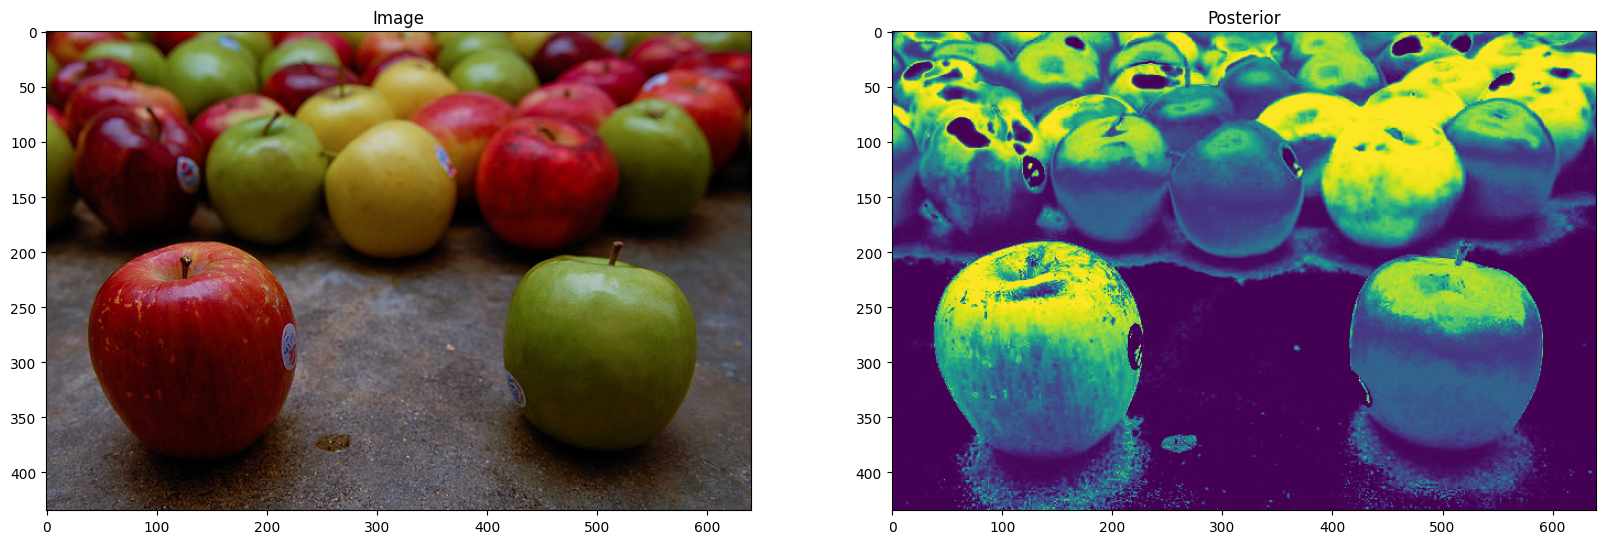

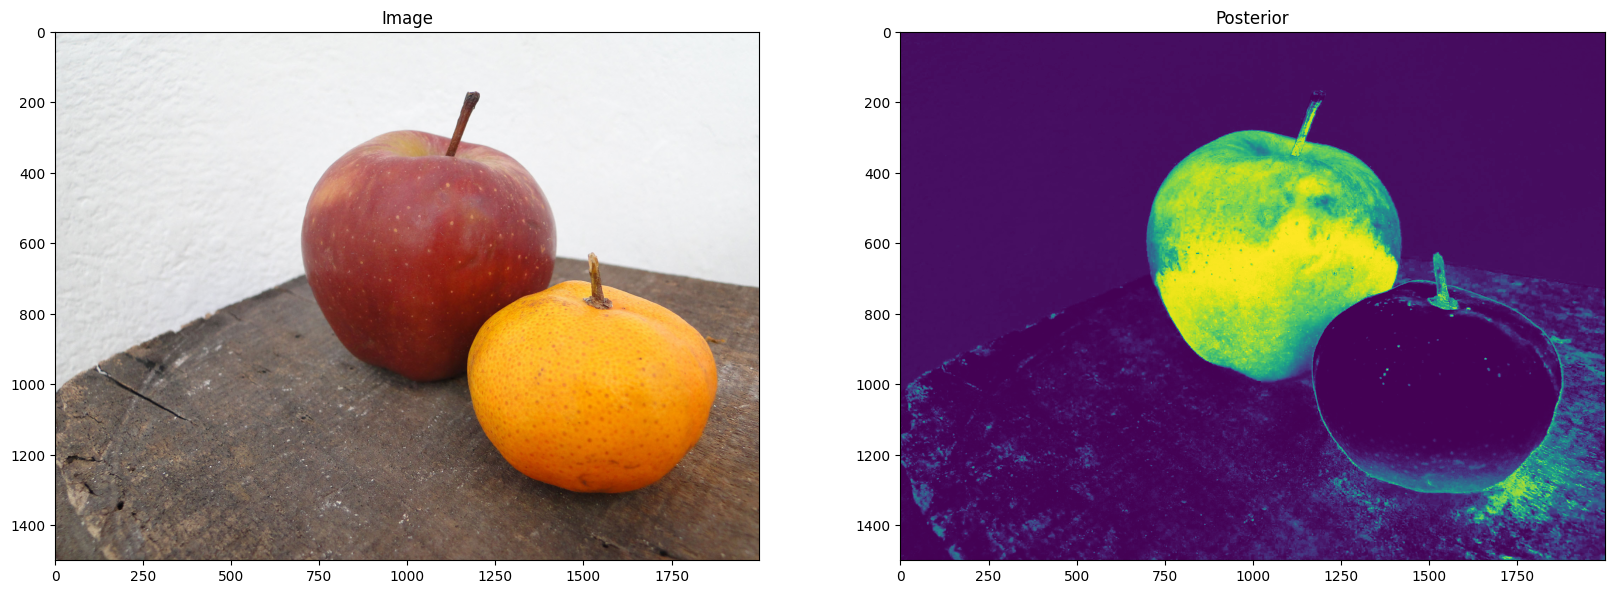

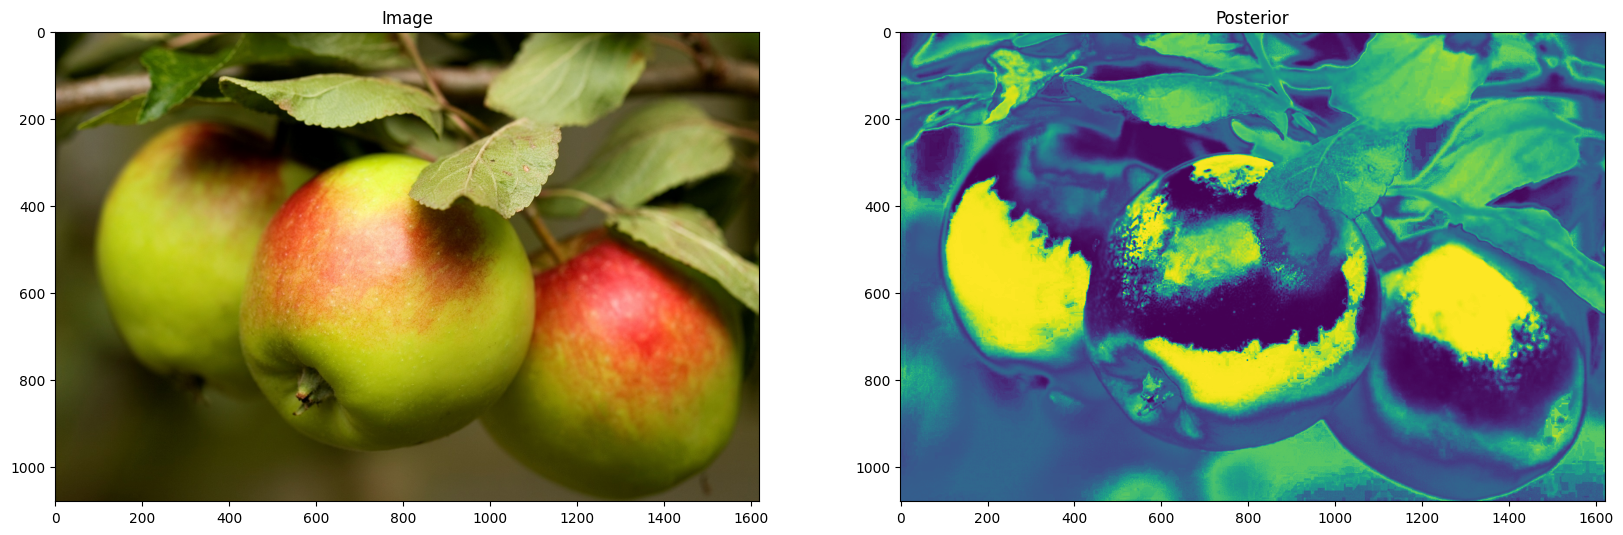

In [565]:
p1 = posterior('./testApples/Apples_by_MSR_MikeRyan_flickr.jpg', prior, mixGassEst_true, mixGassEst_false)
p2 = posterior('./testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg', prior, mixGassEst_true, mixGassEst_false)
p3 = posterior('./testApples/audioworm-QKUJj2wmxuI-original.jpg', prior, mixGassEst_true, mixGassEst_false)


In [602]:
p1.shape

(435, 640)

In [620]:
plt.imread('./testApples/Apples_by_MSR_MikeRyan_flickr.jpg')[:,:][2][1].shape

(3,)

##### D. ROC Curve

In [566]:
def posterior_bin(posterior, threshold = 0.5):
    '''
    Returns the posterior binary of a given threshold.

    Key arguments:
    posterior -- the probability of each pixel being an apple pixel
    threshold -- a value for which if the posterior is greater than this, the pixel is labeled as true. (i.e. it is an apple pixel)
    '''
    return (posterior > threshold).astype(int)


In [567]:
p2_bin = posterior_bin(p2, 0.5)
p2_bin.shape

(1500, 2000)

In [592]:
def roc_curve(post_bin, true_bin):
    '''
    Returns

    Key arguments:
    post_bin -- posterior binary
    true_bin_path -- path of the true binary image
    '''

    # we want to distinguish true positive and false positive,
    # we multipy post_bin by 2 so the differences for
    d = 2 * post_bin - true_bin
    true_p = np.sum(d == 1)
    true_n = np.sum(d == 0)
    false_p = np.sum(d == 2)
    false_n = np.sum(d == -1)

    # Calculate required metrics for F1 and ROC
    sensitivity = true_p / (true_p + false_n + 1e-20)
    specificity = true_n / (true_n + false_p + 1e-20)

    roc = sensitivity * specificity

    return roc, sensitivity, specificity
    


In [593]:
def plot_roc(posterior, true_bin_path):
    true_bin = (plt.imread(true_bin_path)[:,:,0]).astype(int)
    # assert true_bin.shape == post_bin.shape, f"image shapes don't agree {true_bin.shape}, {post_bin.shape}"
    rocs = []
    sensitivity = []
    specificity = []
    for i in range(1,100):
        th = i/100 # threshold
        Post_bin = posterior_bin(posterior, th)
        roc, sens, spec = roc_curve(Post_bin, true_bin)
        rocs.append(roc)
        sensitivity.append(sens)
        specificity.append(spec)
    best_th = rocs.index(max(rocs)) / 100
    plt.plot(1 - np.array(specificity), sensitivity)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')

    pb = posterior_bin(posterior, best_th)
    _, s1, s2 = roc_curve(pb, true_bin)
    plt.plot(1-s2, s1, 'ro-', label=f'Best threshold {best_th}')
    plt.legend()
    return best_th

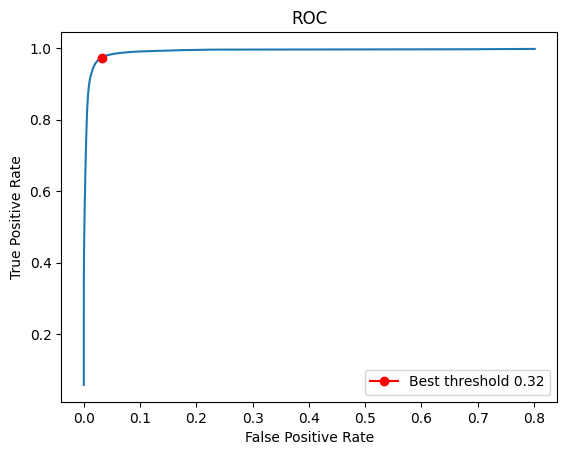

In [595]:
best_threhold = plot_roc(p2, './testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.png')

Figure: ROC Curve

In [586]:
import matplotlib.image
array = plt.imread(('myapple3.png'))[:,:,0]
array = (array == 1.0).astype(int)
matplotlib.image.imsave('myapple3_bin.png', array)

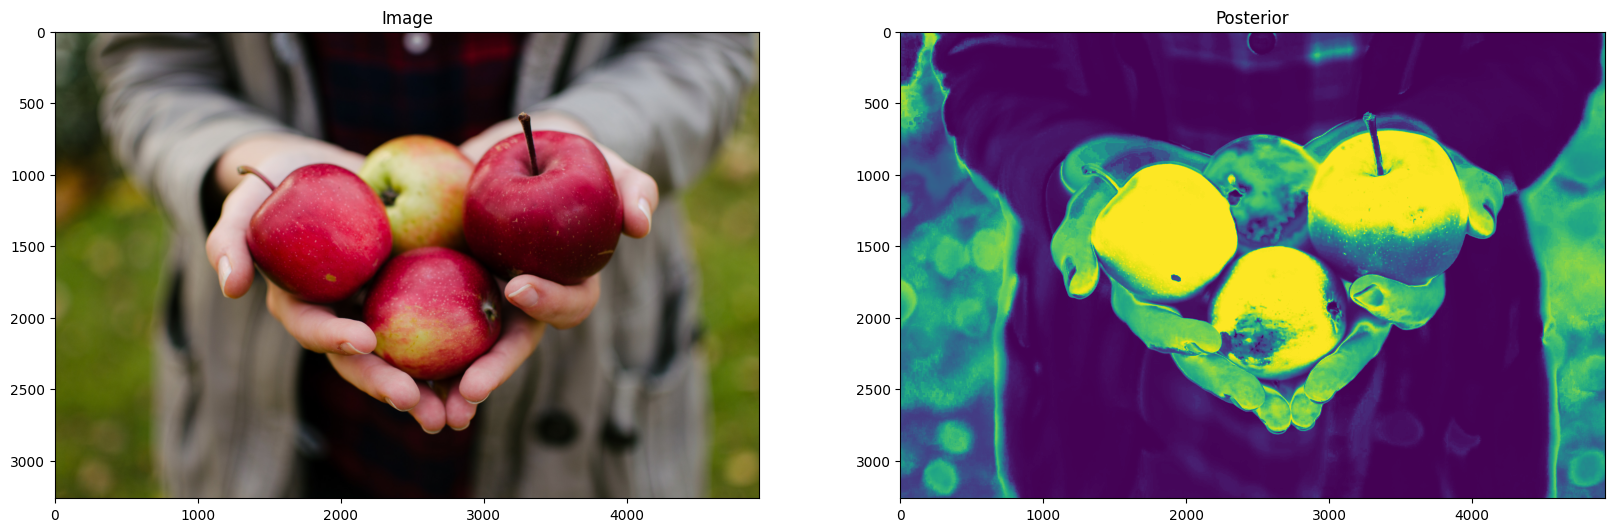

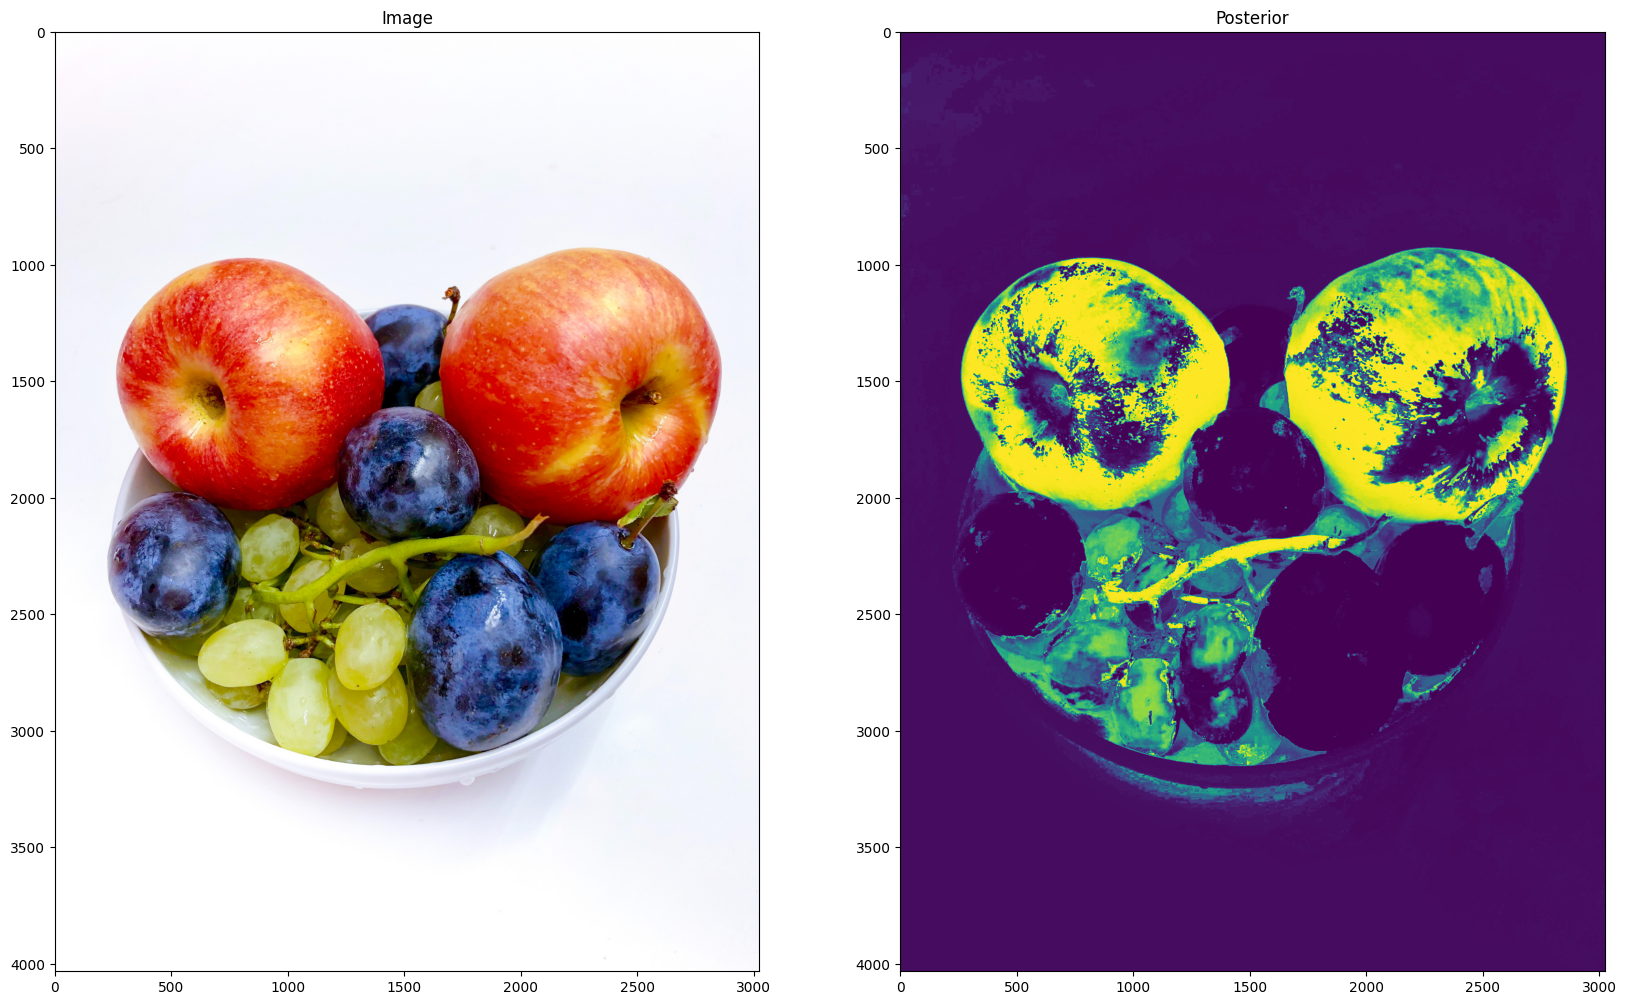

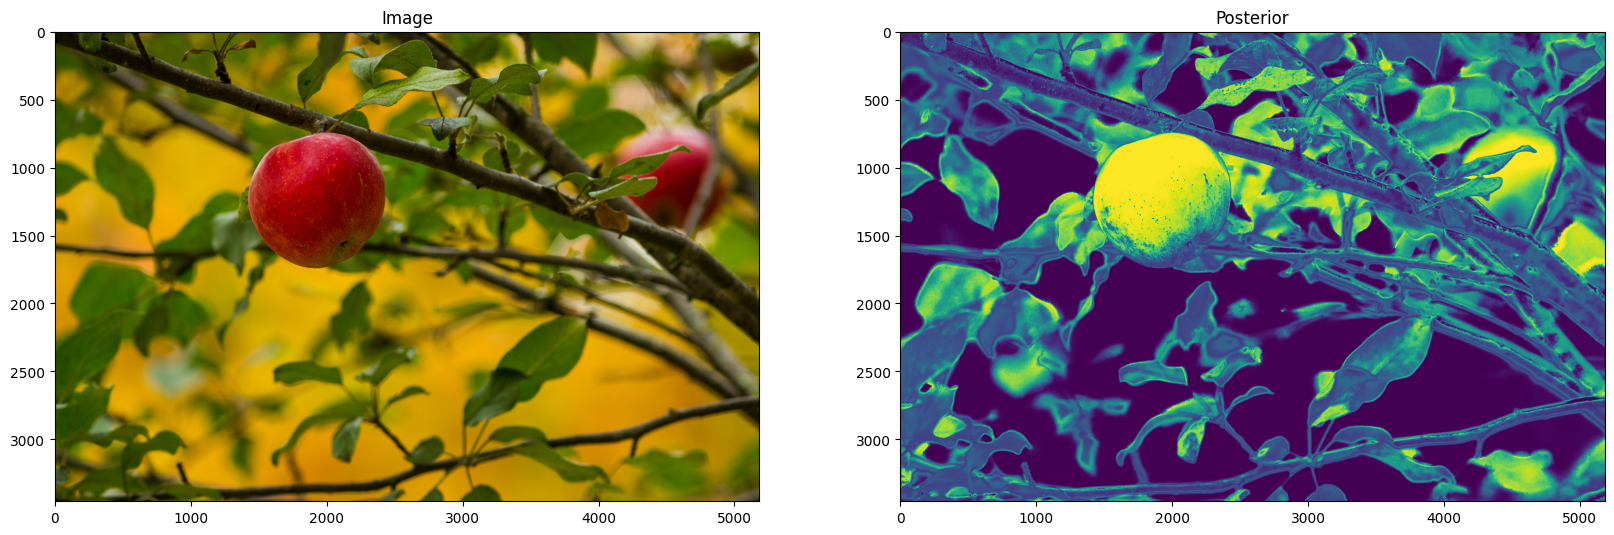

In [581]:
myapple1_post = posterior('myapple1.jpg', prior, mixGassEst_true, mixGassEst_false)
myapple2_post = posterior('myapple2.jpg', prior, mixGassEst_true, mixGassEst_false)
myapple3_post = posterior('myapple3.jpg', prior, mixGassEst_true, mixGassEst_false)

In [589]:
plt.imread('myapple3_bin.png').shape

(3456, 5184, 4)

In [600]:
plt.imread('myapple3.jpg')[:,:,0].shape


(3456, 5184)

In [601]:
myapple1_post.shape

(3264, 4928)

### F) We should really be using three separate sets of files: a training set, a validation set, and test set! Explain why.